# Based on Chuck's NSIP data notebook

In [1]:
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr); library(dplyr)
library(ggplot2)
library(foreach)
library(doParallel)
library(RColorBrewer)
library(gridExtra)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package:

In [3]:
%%R
#Creating the physeq object from our tree and biom table with taxonimic and metadata already included, telling it \
# that the taxonomy is from greengenes database, so it will recognize the samples
physeq = import_biom("../data/otu_table_tax_no211_meta.biom", treefilename = "../data/ssu-aln.bacteria.mask.tre",
                    parseFunction = parse_taxonomy_greengenes)

In [4]:
%%R

get_Ps = function(physeq.obj, l2fc.threshold, Day, Amdmt, sparsity.threshold, test) {
# Creating a function that takes as input a number of variables    
    physeq.md = sample_data(physeq.obj)
    # grabs the sample data from the physeq object
    p = prune_samples((physeq.md$Day == Day)&
                      ((physeq.md$Amdmt == Amdmt) | (physeq.md$Amdmt == 0)), physeq.obj)
    # Takes only the samples from that day that you are interested in (I am interested in days 1 and 2)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > (sparsity.threshold * length(x)), TRUE)
        #Takes that day-specific data table, and then checks to see - if we take the sum of all x values that are greater 
        # than 0, is that greater than our sparsity threshold (specified when we run the function) multipled by the 
        # number of x values we have? I.e., is the average sparsity greater than the sparsity threshold? If so, include it
        # in our new phyloseq object, called p.thresh
    
    dds = phyloseq_to_deseq2(p.thresh, ~Amdmt)
        # Turns phyloseq object into a deseq2 object. The ~Amdmt is telling it that we are interested in the Amdmt
        # parameter (soil amendments), of which we have ensured that our baseline ("0", or no amendment) is first in this list.
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
        # Performs analysis on our data, estimating size factors, dispersion, doing model fitting, and calculating Wald stats.
        # Here we are inputting our dds (previously physeq) table, asking it to not report its data as it works (quiet=TRUE),
        # and using a "local" fit. Other options for fit are parametric and mean. It could also be run in parallel.
        # We have not specified a test - it does Wald and LRT. We have built the option to specify the test into the overall
        # function, defined above. Or maybe not, actually. That might be something different. Maybe Wald is default.

    r = results(dds, independentFiltering = FALSE)
        # We are collecting the report from our DESeq run above.
    beta = r$log2FoldChange
        # From this data report, we can collect the column that is our log2Fold Change
    betaSE = r$lfcSE
        # We are also collecting the standard error from that report
    if (test == "greater") {
        p = pnorm(beta, l2fc.threshold, betaSE, lower.tail = FALSE)
    } else if (test == "less") {
        p = pnorm(beta, l2fc.threshold, betaSE, lower.tail = TRUE)
    }
        # This is a little function to build probability distributions based on the mean and se that came out of our
        # dds report of log2-fold changes. We are finding the upper ("greater") and lower ("lesss") tails.
        # I.e., we will be able to test does it change to become greater, or lesser, and specify this when we run the function.
    r$p = p
        # We are then appending this result to our results table.
    DF = data.frame(r[, c("log2FoldChange", "p")])
        # And, we are adding a nice title to that data table to specify the columns
    
    tax = tax_table(p.thresh)
        # Remember our table filtered to get the taxa beyond the sparsity threshold?
    if (!setequal(row.names(DF), row.names(tax))) {
        stop("Ordination and supplementary data indices differ on the following:\n",
        setdiff(row.names(DF), row.names(tax)))
    }
        # Let's make sure it has the same names as our report table we had above.
    DF = data.frame(DF, tax)
        # So long as it does, we'll merge them now.
        
    DF$OTU = rownames(DF)
    DF$Day = Day
    DF$Amdmt = Amdmt
    DF$sparsity.threshold = as.character(sparsity.threshold)
    DF$test = test    
    # Just making sure the data table has an OTU column, all have the right value for Day, and what test we used,
        # And also input our sparsity threshold.
    DF
}

In [5]:
%%R
# expand.grid makes a dataframe with each of the possible combinations of values here. if we're not using sparsity threshold
# we could cut it out, I think. Actually, what it is doing, is telling us which taxa we include in the analysis.
# i.e., how sparse are the total sum of these taxa? If they, combined, make up less than 
m = expand.grid(sparsity.threshold = seq(0.05,0.75,0.025), 
                Day = c(1, 2),
                Amdmt = c(1,2),
                l2fc.threshold = 0.25,
                # sets the log 2-fold change threshold we're interested in at 0.25
                test = c("greater", "less"))

registerDoParallel(10)
# sets number of processors to use

df.l2fc = tbl_df(mdply(m, get_Ps, .parallel = TRUE, physeq.obj = physeq))

#Takes data (m), runs a fucntion on it (get_Ps), defines the physeq data, which is needed as input, and does it in parallel.
# i.e., it runs the get_Ps function on all possible combinations of day, amendment, and l2fc threshold
# (and sparsity threshold, if included) that are listed above.

df.l2fc


Source: local data frame [886,762 x 16]

   l2fc.threshold log2FoldChange         p  Kingdom         Phylum
1            0.25     0.02512231 0.7254573 Bacteria Actinobacteria
2            0.25    -0.19592034 0.9028765 Bacteria Proteobacteria
3            0.25    -0.32718355 0.9786238 Bacteria Proteobacteria
4            0.25    -0.25792476 0.9674765 Bacteria Proteobacteria
5            0.25    -0.02696807 0.9860030 Bacteria  Acidobacteria
6            0.25    -0.08369106 0.9540556 Bacteria  Acidobacteria
7            0.25    -0.08830341 0.9851367 Bacteria  Acidobacteria
8            0.25    -0.05885929 0.9506722 Bacteria  Acidobacteria
9            0.25     0.07194251 0.6825248 Bacteria  Acidobacteria
10           0.25    -0.12433492 0.8466705 Bacteria  Acidobacteria
..            ...            ...       ...      ...            ...
Variables not shown: Class (fctr), Order (fctr), Family (fctr), Genus (fctr),
  Species (fctr), Rank1 (fctr), OTU (chr), Day (dbl), Amdmt (dbl),
  sparsity

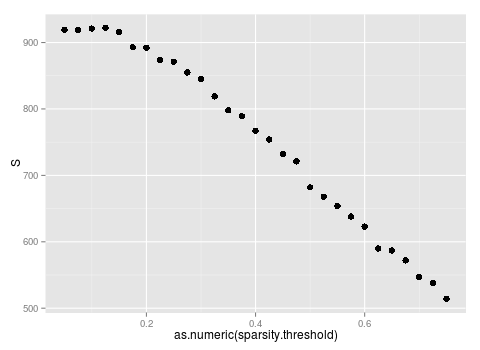

In [6]:
%%R -h 350
# Sets up the graph size
d = df.l2fc %.%
    filter(test == "greater") %.%
    group_by("sparsity.threshold") %.%
    mutate(p.adj = p.adjust(p, "BH"))
# Here, we are interested in that final dataframe created above, filtering it so we're only looking at the "greater" tests
# grouping them by sparsity threshold
# making the p values into benjamini-hochberg p values (similar to false discovery rate)

FDR = 0.05
# Setting the false discovery rate

d = ddply(d, .(sparsity.threshold), summarize, S = sum(p.adj < FDR))
# making the new data frame from d, where S is defined as the sum of the number of (taxa? samples?) where our 
# adjusted p value is lower than the false discovery rate we are okay with.

p = ggplot(d, aes(x = as.numeric(sparsity.threshold), y = S)) + geom_point(size = 3)
# making the plot nice

p
# plotting it
# as expected, as the sparsity threshold increases, fewer and fewer taxa make the cutoff, where the adjusted p value
# is less than 0.05, our false discovery rate. At higher sparsity thresholds, we excluded more and more of the taxa.
# We will have just over 900 taxa, if we have a sparsity threshold below 0.15.


In [7]:
%%R

df.l2fc.indepfilt = df.l2fc %.%
                    filter(sparsity.threshold == "0.15")
# Filtering the data table so we are setting the sparsity threshold here
# Should be based on the plot above

df.l2fc.padj = df.l2fc.indepfilt %.% 
                filter(test == "greater") %.%
                mutate(p.adj = p.adjust(p, method = "BH")) %.%
                select(OTU, test, sparsity.threshold, p.adj, p)
# Pulling out those same values

df.l2fc.indepfilt = left_join(df.l2fc.indepfilt, df.l2fc.padj)
# Connecting the two tables

Joining by: c("p", "OTU", "sparsity.threshold", "test")


In [8]:
%%R
head(df.l2fc.indepfilt)

Source: local data frame [6 x 17]

  l2fc.threshold log2FoldChange         p  Kingdom         Phylum
1           0.25     0.02535691 0.7305051 Bacteria Actinobacteria
2           0.25    -0.19348863 0.9052466 Bacteria Proteobacteria
3           0.25    -0.32435377 0.9790843 Bacteria Proteobacteria
4           0.25    -0.25595259 0.9681219 Bacteria Proteobacteria
5           0.25    -0.02692599 0.9860554 Bacteria  Acidobacteria
6           0.25    -0.08336698 0.9545776 Bacteria  Acidobacteria
Variables not shown: Class (fctr), Order (fctr), Family (fctr), Genus (fctr),
  Species (fctr), Rank1 (fctr), OTU (chr), Day (dbl), Amdmt (dbl),
  sparsity.threshold (chr), test (fctr), p.adj (dbl)


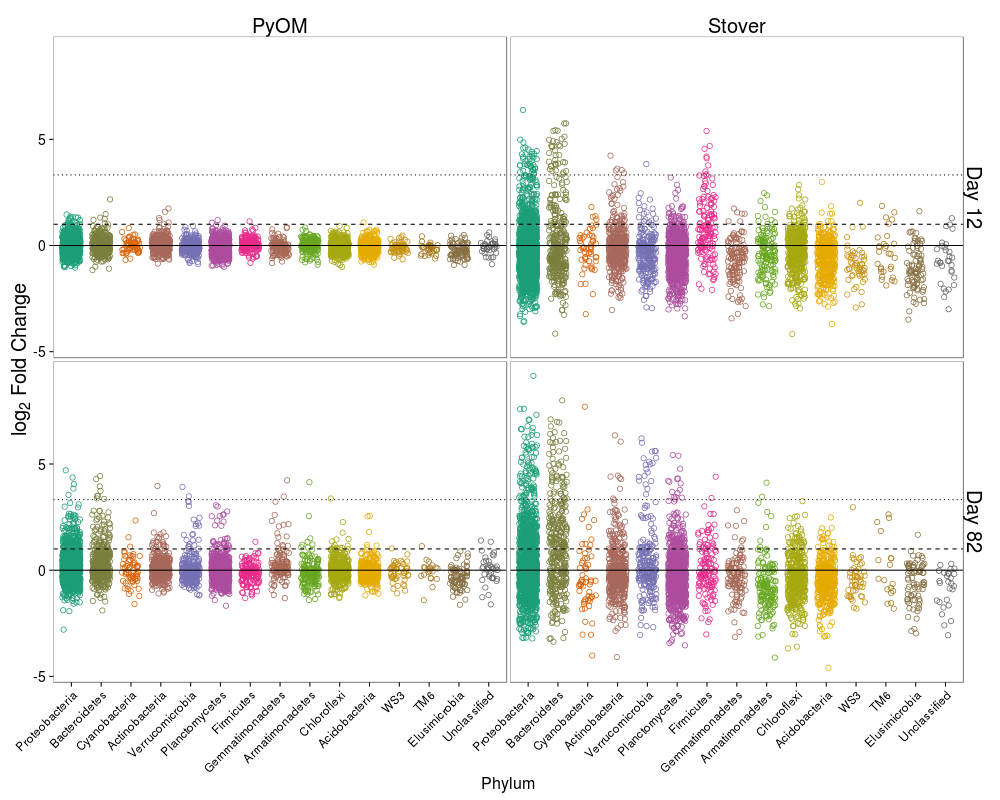

In [186]:
%%R -w 1000 -h 800
# setting the image sizes, then making the figure...

d = df.l2fc.indepfilt %>% filter(test == "greater")
# filters out our table to include only the "greater" tests - which were significantly above the threshold? No - just 
# seeing whether they were greater or not.


d$Phylum = substr(as.character(d$Phylum),0,nchar(as.character(d$Phylum)))
# makes the Rank2 column of our d table a character. Rank 2 was the phyla of our communities

d$Phylum[is.na(d$Phylum)] <- "Unclassified"
# if there is an NA in the Rank2 column, then it gets called "unclassified"

d$Phylum = factor(d$Phylum)
# Establishes that Rank2 is a factor.

levels(d$Phylum)[levels(d$Phylum) == "[Thermi]"] <- "Thermi"
levels(d$Phylum)[levels(d$Phylum) == ""] <- "Unclassified"
levels(d$Phylum)[levels(d$Phylum) == "NA"] <- "Unclassified"
# Fixes two phylum labelling issues

N=100
Phyla = levels(d$Phylum)

NPhylum <- function (x){
    m = c()
    for (i in x){
       L <- length(d$Phylum[d$Phylum==i])
    if (L > N) m = c(m,i)
        }
        m
    }

Include<-as.factor(NPhylum(Phyla))
d<-d[d$Phylum %in% Include,]
d$Phylum<-factor(d$Phylum)


d$DayName = ifelse(d$Day==1,"Day 12","Day 82")
d$strip1 = paste(d$DayName)
d$AmdmtName = ifelse(d$Amdmt==1,"PyOM","Stover")
d$AmdmtName <- factor(d$AmdmtName, levels = c("Stover","PyOM"))
d$strip2 = paste(d$AmdmtName)
# Creates a "strip" column of d with either Day or Amendment

max.l2fc = ddply(d, .(Phylum), summarize, M = max(log2FoldChange))
# makes a dataframe with the maximum value of log2Fold change for each phylum
d$Phylum = factor(d$Phylum, max.l2fc[order(-max.l2fc$M),]$Phylum)
# takes our phylum column, and arranges it in order of our log2FoldChange values
#d$color = ifelse(d$p.adj <= 0.05, "yes", "no")
# looks at the p.adj value, to see if it's less than or equal to what we set it to here.
# If it is less ("significant") then we label it yes. Otherwise, no.

M = max(as.numeric(d$Phylum), na.rm = TRUE) + 1
d$x = as.numeric(d$Phylum)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.25

p = ggplot(d, aes(x = Phylum, y = log2FoldChange, color = Phylum))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

p = p + facet_grid(strip1~strip2)
# saying we want it to present the data separately for our two variables (day and amendment), in 2 columns

p = p + geom_point(shape = 21, size = 2.5, position = position_jitter(w = 0.30))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

# p = p + scale_color_manual(values = c("lightblue2", "darkslategrey"))
# sets the colour values to be black or red

p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
# puts in a horizontal line at our cutoff value

p = p + geom_hline(y = 0.0, linetype=1)
# puts in a horizontal line at our cutoff value

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 20),
              strip.text.y = element_text(size = 20),
              axis.text.x = element_text(size = 12, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 16),
              axis.text.y = element_text(size=14),
              axis.title.y = element_text(size = 20),
              legend.title = element_blank(),
              legend.text = element_text(size = 14),
              legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text

p = p + labs(x = "Phylum", color = "Phylum")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))
# sets the label for the y axes.

colourCount = length(unique(d$Phylum))
getPalette = colorRampPalette(brewer.pal(20, "Dark2"))
p = p + scale_colour_manual(values=getPalette(colourCount))

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
# Would be cool to colour this by relative abundance in soil to begin with.. what drives patterns more?
    
p

In [188]:
%%R
ggsave(filename = "4xLog2.pdf", plot = p, width=9, height = 6.5)

In [11]:
%%R
d = df.l2fc.indepfilt %>% filter(test == "greater")
d$Rank2 = substr(as.character(d$Rank2),4,nchar(as.character(d$Rank2)))
d$Rank2[is.na(d$Rank2)] = "Unclassified"
d$Rank2 = factor(d$Rank2)
d$Signif = ifelse(d$p.adj <= 0.05, "yes", "no")

# Does the same stuff as above

# I want to, for each day, figure out 1) which taxa are the ones that are significantly higher
# 2) figure out whether they are the same in each amendment type.
# How would this information best be presented? Could be a Venn diagram. But something probably better.

In [12]:
%%R
d.12.stover<-d[d$Signif == "yes" & d$Day=="1" & d$Amdmt=="2",]
d.12.PyOM<-d[d$Signif == "yes" & d$Day=="1" & d$Amdmt=="1",]
d.82.stover<-d[d$Signif == "yes" & d$Day=="2" & d$Amdmt=="2",]
d.82.PyOM<-d[d$Signif == "yes" & d$Day=="2" & d$Amdmt=="1",]
# Subsets the table by day and amendment

In [13]:
%%R
d.82.PyOM

Source: local data frame [199 x 17]

              p      OTU sparsity.threshold    test l2fc.threshold
1  4.092487e-06 OTU.7041               0.15 greater           0.25
2  7.328561e-17 OTU.6190               0.15 greater           0.25
3  1.366326e-07 OTU.3373               0.15 greater           0.25
4  8.254333e-10    OTU.3               0.15 greater           0.25
5  4.439181e-04 OTU.3553               0.15 greater           0.25
6  1.806551e-03  OTU.177               0.15 greater           0.25
7  1.965124e-08  OTU.442               0.15 greater           0.25
8  3.106588e-06  OTU.673               0.15 greater           0.25
9  1.051122e-09  OTU.166               0.15 greater           0.25
10 3.610534e-10   OTU.33               0.15 greater           0.25
..          ...      ...                ...     ...            ...
Variables not shown: log2FoldChange (dbl), Rank1 (fctr), Rank2 (fctr), Rank3
  (fctr), Rank4 (fctr), Rank5 (fctr), Rank6 (fctr), Rank7 (fctr), Day (dbl),
  Amd

In [14]:
%%R
d.12.shared<-d.12.PyOM[d.12.PyOM$OTU %in% d.12.stover$OTU,]
d.12.notshared<-d.12.PyOM[(d.12.PyOM$OTU %in% d.12.stover$OTU)==FALSE,]
d.82.shared<-d.82.PyOM[d.82.PyOM$OTU %in% d.82.stover$OTU,]
d.82.notshared<-d.82.PyOM[(d.82.PyOM$OTU %in% d.82.stover$OTU)==FALSE,]
# Figures out which taxa are common to both amendment types for each day
# Now how do I represent that best? Maybe a bar chart... HAH no way.
# Fast responders list...

In [15]:
%%R
counts.ns <- table(d.82.notshared$Rank2)
counts.s <- table(d.82.shared$Rank2)
# Tally up the number of OTUs for each phylum
shared.comb<-rbind(counts.ns, counts.s)
shared.comb<-t(shared.comb)
shared.comb<-as.data.frame(shared.comb)
# Join the ns and s into one data frame

shared.comb <- shared.comb[counts.ns!=0 | counts.s!=0,]
# Get rid of unrepresented phyla
shared.comb

                 counts.ns counts.s
Acidobacteria            5        0
Actinobacteria           7        7
Armatimonadetes          0        2
Bacteroidetes           25       18
BRC1                     0        2
Chlorobi                 3        0
Chloroflexi              3        0
Cyanobacteria            2        0
FBP                      1        0
Gemmatimonadetes        11        1
Planctomycetes          12        3
Proteobacteria          38       44
Verrucomicrobia          5       10


In [16]:
%%R
counts.ns <- table(d.82.notshared$Rank3[d.82.notshared$Rank2=="Proteobacteria"])
counts.s <- table(d.82.shared$Rank3[d.82.shared$Rank2=="Proteobacteria"])
# Tally up the number of OTUs for each phylum
shared.comb<-rbind(counts.ns, counts.s)
shared.comb<-t(shared.comb)
shared.comb<-as.data.frame(shared.comb)
# Join the ns and s into one data frame

shared.comb <- shared.comb[counts.ns!=0 | counts.s!=0,]
# Get rid of unrepresented phyla
shared.comb

                       counts.ns counts.s
c__Alphaproteobacteria        12       27
c__Betaproteobacteria         11       10
c__Deltaproteobacteria        12        1
c__Gammaproteobacteria         3        6


In [17]:
%%R
counts.ns <- table(d.82.notshared$Rank3[d.82.notshared$Rank2=="Bacteroidetes"])
counts.s <- table(d.82.shared$Rank3[d.82.shared$Rank2=="Bacteroidetes"])
# Tally up the number of OTUs for each phylum
shared.comb<-rbind(counts.ns, counts.s)
shared.comb<-t(shared.comb)
shared.comb<-as.data.frame(shared.comb)
# Join the ns and s into one data frame

shared.comb <- shared.comb[counts.ns!=0 | counts.s!=0,]
# Get rid of unrepresented phyla
shared.comb

                    counts.ns counts.s
c__At12OctB3                0        1
c__Cytophagia               4        4
c__Flavobacteriia           1        2
c__[Saprospirae]           15        6
c__Sphingobacteriia         5        5


In [18]:
%%R
counts.ns <- table(d.82.notshared$Rank3[d.82.notshared$Rank2=="Verrucomicrobia"])
counts.s <- table(d.82.shared$Rank3[d.82.shared$Rank2=="Verrucomicrobia"])
# Tally up the number of OTUs for each phylum
shared.comb<-rbind(counts.ns, counts.s)
shared.comb<-t(shared.comb)
shared.comb<-as.data.frame(shared.comb)
# Join the ns and s into one data frame

shared.comb <- shared.comb[counts.ns!=0 | counts.s!=0,]
# Get rid of unrepresented phyla
shared.comb

                    counts.ns counts.s
c__[Pedosphaerae]           2        0
c__[Spartobacteria]         1        5
c__Verrucomicrobiae         2        5


In [19]:
%%R
counts.ns <- table(d.82.notshared$Rank3[d.82.notshared$Rank2=="Gemmatimonadetes"])
counts.s <- table(d.82.shared$Rank3[d.82.shared$Rank2=="Gemmatimonadetes"])
# Tally up the number of OTUs for each phylum
shared.comb<-rbind(counts.ns, counts.s)
shared.comb<-t(shared.comb)
shared.comb<-as.data.frame(shared.comb)
# Join the ns and s into one data frame

shared.comb <- shared.comb[counts.ns!=0 | counts.s!=0,]
# Get rid of unrepresented phyla
shared.comb

                    counts.ns counts.s
c__Gemm-3                   3        0
c__Gemm-5                   1        0
c__Gemmatimonadetes         7        1


In [20]:
%%R
columns<-c(2,6:13)
Gemm <- d.82.notshared[d.82.notshared$Rank2=="Gemmatimonadetes",columns]
Gemm[,5:9]

Source: local data frame [11 x 5]

                 Rank3               Rank4                Rank5           Rank6
1            c__Gemm-5                 o__                  f__             g__
2  c__Gemmatimonadetes o__Gemmatimonadales f__Gemmatimonadaceae g__Gemmatimonas
3  c__Gemmatimonadetes        o__Ellin5290                  f__             g__
4            c__Gemm-3                 o__                  f__             g__
5  c__Gemmatimonadetes o__Gemmatimonadales         f__Ellin5301             g__
6  c__Gemmatimonadetes        o__Ellin5290                  f__             g__
7            c__Gemm-3                 o__                  f__             g__
8  c__Gemmatimonadetes        o__Ellin5290                  f__             g__
9  c__Gemmatimonadetes                  NA                   NA              NA
10 c__Gemmatimonadetes o__Gemmatimonadales         f__Ellin5301             g__
11           c__Gemm-3                 o__                  f__             g__
Varia

## Shared/not shared from Stover point of view

In [21]:
%%R
d.12.shared.S<-d.12.stover[d.12.stover$OTU%in% d.12.PyOM$OTU ,]
d.12.notshared.S<-d.12.stover[(d.12.stover$OTU %in% d.12.PyOM$OTU )==FALSE,]
d.82.shared.S<-d.82.stover[d.82.stover$OTU %in% d.82.PyOM$OTU ,]
d.82.notshared.S<-d.82.stover[(d.82.stover$OTU%in% d.82.PyOM$OTU )==FALSE,]
# Figures out which taxa are common to both amendment types for each day
counts.ns.S <- table(d.82.notshared.S$Rank2)
counts.s.S <- table(d.82.shared.S$Rank2)
# Tally up the number of OTUs for each phylum
shared.comb.S<-rbind(counts.ns.S, counts.s.S)
shared.comb.S<-t(shared.comb.S)
shared.comb.S<-as.data.frame(shared.comb.S)
# Join the ns and s into one data frame

shared.comb.S <- shared.comb.S[counts.ns.S!=0 | counts.s.S!=0,]
# Get rid of unrepresented phyla
shared.comb.S

                 counts.ns.S counts.s.S
Acidobacteria              4          0
Actinobacteria            30          7
Armatimonadetes            2          2
Bacteroidetes             89         18
BRC1                       0          2
Chlorobi                   1          0
Chloroflexi                3          0
Cyanobacteria              2          0
Elusimicrobia              1          0
FBP                        1          0
Fibrobacteres              1          0
Firmicutes                 8          0
Gemmatimonadetes           2          1
Planctomycetes            40          3
Proteobacteria           160         44
Spirochaetes               4          0
Verrucomicrobia           24         10


## How do PyOM and Stover breakdown of Proteo classes compare?

In [22]:
%%R
counts <- table(d.82.stover$Rank3[d.82.stover$Rank2=="Proteobacteria"])
counts<-t(counts)
counts<-as.data.frame(counts)

counts <- counts[counts$Freq!=0,]
# Get rid of unrepresented phyla
counts

   Var1                   Var2 Freq
11    A c__Alphaproteobacteria  110
18    A  c__Betaproteobacteria   23
31    A c__Deltaproteobacteria   27
39    A c__Gammaproteobacteria   44


In [23]:
%%R
counts <- table(d.82.PyOM$Rank3[d.82.PyOM$Rank2=="Proteobacteria"])
counts<-t(counts)
counts<-as.data.frame(counts)

counts <- counts[counts$Freq!=0,]
# Get rid of unrepresented phyla
counts

   Var1                   Var2 Freq
11    A c__Alphaproteobacteria   39
18    A  c__Betaproteobacteria   21
31    A c__Deltaproteobacteria   13
39    A c__Gammaproteobacteria    9


## Trying to make a figure for DEB

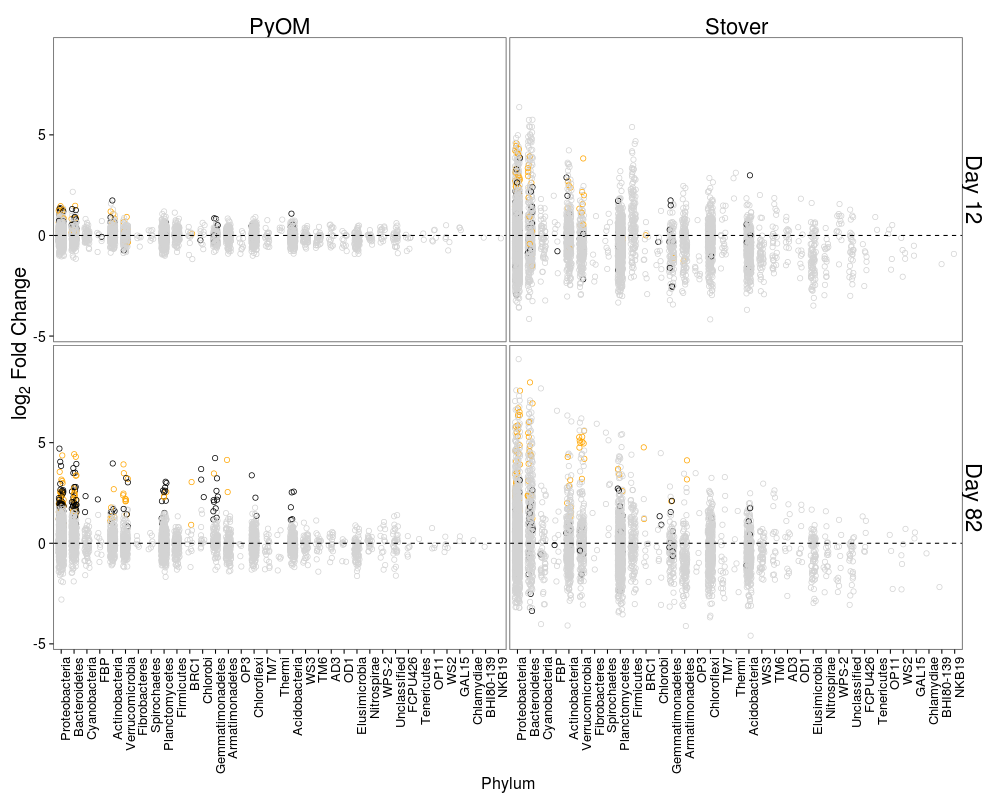

In [42]:
%%R -w 1000 -h 800
# setting the image sizes, then making the figure...

d = df.l2fc.indepfilt %>% filter(test == "greater")
# filters out our table to include only the "greater" tests - which were significantly above the threshold? No - just 
# seeing whether they were greater or not.

d$Rank2 = substr(as.character(d$Rank2),4,nchar(as.character(d$Rank2)))
# makes the Rank2 column of our d table a character. Rank 2 was the phyla of our communities

d$Rank2[is.na(d$Rank2)] = "Unclassified"
# if there is an NA in the Rank2 column, then it gets called "unclassified"

d$Rank2 = factor(d$Rank2)
# Establishes that Rank2 is a factor.

levels(d$Rank2)[levels(d$Rank2) == "[Thermi]"] <- "Thermi"
levels(d$Rank2)[levels(d$Rank2) == ""] <- "Unclassified"
# Fixes two phylum labelling issues

d$DayName = ifelse(d$Day==1,"Day 12","Day 82")
d$strip1 = paste(d$DayName)
d$AmdmtName = ifelse(d$Amdmt==1,"PyOM","Stover")
d$AmdmtName <- factor(d$AmdmtName, levels = c("Stover","PyOM"))
d$strip2 = paste(d$AmdmtName)
# Creates a "strip" column of d with either Day or Amendment

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
# makes a dataframe with the maximum value of log2Fold change for each phylum
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)
# takes our phylum column, and arranges it in order of our log2FoldChange values

d$Signif = ifelse(d$p.adj <= 0.05, "yes", "no")
d.82.stover<-d[d$Signif == "yes" & d$Day=="2" & d$Amdmt=="2",]
d.82.PyOM<-d[d$Signif == "yes" & d$Day=="2" & d$Amdmt=="1",]
d.82.shared<-d.82.PyOM[d.82.PyOM$OTU %in% d.82.stover$OTU,]
d.82.notshared<-d.82.PyOM[(d.82.PyOM$OTU %in% d.82.stover$OTU)==FALSE,]
# Sets up shared from PyOM point of view

d.12.shared.S<-d.12.stover[d.12.stover$OTU%in% d.12.PyOM$OTU ,]
d.12.notshared.S<-d.12.stover[(d.12.stover$OTU %in% d.12.PyOM$OTU )==FALSE,]
d.82.shared.S<-d.82.stover[d.82.stover$OTU %in% d.82.PyOM$OTU ,]
d.82.notshared.S<-d.82.stover[(d.82.stover$OTU%in% d.82.PyOM$OTU )==FALSE,]
# Sets up shared from stover point of view

d$PyOMunique<-ifelse(d$OTU %in% d.82.shared$OTU, "shared", ifelse(d$OTU %in% d.82.notshared$OTU, "unique", "other"))
d$Stoverunique<-ifelse(d$OTU %in% d.82.shared.S$OTU, "shared", ifelse(d$OTU %in% d.82.notshared.S$OTU, "unique", "other"))
# Figures out which taxa are common to both amendment types for each day
###This is the big change from above - takes the tables calculated above (awkward, should be integrated), and 
d$color = ifelse(d$p.adj <= 0.05, "yes", "no")
# looks at the p.adj value, to see if it's less than or equal to what we set it to here.
# If it is less ("significant") then we label it yes. Otherwise, no.

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.25

p = ggplot(d, aes(x = Rank2, y = log2FoldChange, color = PyOMunique))
# Change this for Stoverunique or PyOMunique
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.
# Now changed to PyOM unique set

p = p + facet_grid(strip1~strip2)
# saying we want it to present the data separately for our two variables (day and amendment), in 2 columns

p = p + geom_point(shape = 21, size = 2.5, position = position_jitter(w = 0.20))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_color_manual(values = c("lightgrey", "orange","black"))
# sets the colour values to be black or red

#p = p + geom_hline(y = 0.25, linetype="dashed")
# puts in a horizontal line at our cutoff value

p = p + geom_hline(y = 0.0, linetype="dashed")
# puts in a horizontal line at our cutoff value

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 22),
              strip.text.y = element_text(size = 22),
              axis.text.x = element_text(size = 13, angle = 90, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 16),
              axis.text.y = element_text(size=14),
              axis.title.y = element_text(size = 20),
              legend.title = element_blank(),
              legend.text = element_text(size = 14),
              legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text

p = p + labs(x = "Phylum", color = "Phylum")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))
# sets the label for the y axes.

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

p

In [43]:
%%R
ggsave(filename = "4xLog2DEBPyOM.pdf", plot = p, width=12, height = 8)

In [ ]:
%%R
length(d$Rank2[d$Rank2 %in% max.l2fc[order(-max.l2fc$M),]$Rank2[1:19]])
#problem
#d <- d[d$Rank2[d$Rank2 %in% max.l2fc[order(-max.l2fc$M),]$Rank2[1:19]]]